In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl
import dotenv


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))


dotenv.load_dotenv(ROOT.joinpath(".env"))

from src.utils import check_gpu_available

GPU = check_gpu_available()
print(f"GPU available: {GPU}")

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU available: True


## Read in the Trajectories


In [2]:
processed_traj_df = pl.scan_parquet(
    # Path(os.environ.get("RAW_DATA_DIR")).joinpath("*.parquet")
    ROOT
    / "data/merged_march.parquet"
).select(
    [
        "epoch_time",
        "lane",
        "lane_index",
        "s_velocity_smooth",
        "vehicle_id",
        "front_s_smooth",
        "association_distance",
        "length_s",
    ]
)

In [3]:
# processed_traj_df.head()

In [4]:
lf_df = (
    processed_traj_df.lazy()
    .select(
        [
            "epoch_time",
            "lane",
            "lane_index",
            "front_s_smooth",
            "vehicle_id",
            "s_velocity_smooth",
        ]
    )
    .with_row_count(name="row_count")
    .sort(["epoch_time", "front_s_smooth"])
    .with_columns(
        pl.col(["vehicle_id", "front_s_smooth"])
        .shift(-1)
        .over(["epoch_time", "lane", "lane_index"])
        .name.map(lambda x: f"{x}_leader")
    )
    .filter(pl.col("vehicle_id_leader").is_not_null())
    .with_columns(
        ((pl.col("epoch_time").diff().dt.total_milliseconds() / 1000) > 0.1)
        .cum_sum()
        .over(["vehicle_id", "vehicle_id_leader", "lane", "lane_index"])
        .alias("other_leader"),
        pl.col("s_velocity_smooth")
        .rolling_mean(
            window_size=int(5 / 0.1),
            center=True,
            min_periods=1,
        )
        .over(
            [
                "vehicle_id",
                "lane",
            ]
        )
        .alias("s_velocity_smooth_rolling"),
        (pl.col("front_s_smooth_leader") - pl.col("front_s_smooth")).alias("dist_diff"),
        (
            (pl.col("front_s_smooth_leader") - pl.col("front_s_smooth"))
            / pl.col("s_velocity_smooth")
        ).alias("time_headway"),
        (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
        .over(["vehicle_id", "lane"])
        .alias("time_diff"),
    )
    .with_columns(
        (pl.col("s_velocity_smooth_rolling").diff() / pl.col("time_diff"))
        .over(["vehicle_id", "lane"])
        .alias("acceleration")
    )
    .group_by(["lane", "lane_index", "vehicle_id", "vehicle_id_leader", "other_leader"])
    .agg(
        (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
        .sum()
        .alias("time_diff"),
        pl.col("dist_diff").mean().alias("dist_diff"),
        pl.col("dist_diff").min().alias("dist_diff_min"),
        pl.col("dist_diff").max().alias("dist_diff_max"),
        pl.col("time_headway").mean().alias("time_headway"),
        pl.col("time_headway").min().alias("time_headway_min"),
        pl.col("time_headway").max().alias("time_headway_max"),
        pl.col("row_count").min().alias("start_index"),
        pl.col("row_count").max().alias("end_index"),
        pl.col("acceleration").min().alias("min_acceleration"),
        pl.col("acceleration").max().alias("max_acceleration"),
        # pl.col('s_velocity_smooth_rolling').filter(
        #     pl.col('s_velocity_smooth_rolling').peak_min()
        # ).max().alias('mins'),
        # pl.col('s_velocity_smooth_rolling').filter(
        #     pl.col('s_velocity_smooth_rolling').peak_max()
        # ).mean().alias('maxs'),
        # pl.col('s_velocity_smooth_rolling').peak_max().sum().alias('v_maxs'),
        # pl.col(),
    )
    .filter(
        pl.col("vehicle_id_leader").is_not_null()
        & (pl.col("dist_diff_min") > 5)
        & pl.col("other_leader").is_not_null()
    )
    # .filter(
    #     pl.col("time_headway_min").is_between(0, 10)
    #     & pl.col("time_headway").is_between(0, 10)
    #     & (pl.col("time_diff") > 10)
    #     # &
    # )
    .collect(streaming=True)
)

In [5]:
lf_df.shape

(267923, 16)

### Create a DataFrame of Association Likelihood Scores

In [6]:
assoc_df = (
    processed_traj_df.lazy()
    .group_by(["vehicle_id"])
    .agg(
        pl.col("association_distance").mean().fill_null(0).alias("association_distance")
    )
    .collect(streaming=True)
)

assoc_df.head()

vehicle_id,association_distance
u64,f32
3802,3.632444
29365,13.598371
54270,0.0
9837,2.879454
8390,6.589679


## Join the Two DataFrames

In [7]:
lf_df = lf_df.join(assoc_df, on="vehicle_id", how="left").join(
    assoc_df.rename({"vehicle_id": "vehicle_id_leader"}),
    on="vehicle_id_leader",
    how="left",
    suffix="_leader",
)

In [8]:
lf_df

lane,lane_index,vehicle_id,vehicle_id_leader,other_leader,time_diff,dist_diff,dist_diff_min,dist_diff_max,time_headway,time_headway_min,time_headway_max,start_index,end_index,min_acceleration,max_acceleration,association_distance,association_distance_leader
str,u16,u64,u64,u32,f64,f64,f64,f64,f64,f64,f64,u32,u32,f64,f64,f32,f32
"""WBL1""",2,72713,23,0,1.0,470.074148,469.128499,472.266281,46.906404,45.853451,49.536788,2315619,2645499,-1.21912,-0.942488,0.0,1.710295
"""EBL1""",1,25,11,2,0.0,231.897373,231.897373,231.897373,9.702321,9.702321,9.702321,5647559,5647559,-0.176983,-0.176983,1.950241,2.253739
"""EBL1""",0,48617,27,0,3.8,172.890973,157.575967,193.268979,4.5284e6,-8.7638e6,1.7769e7,10067519,10067892,-0.001221,0.000282,0.0,2.767724
"""WBL1""",0,51088,69,0,1.3,105.203579,103.526843,106.858629,4.665719,4.572247,4.817242,13678929,14105862,-0.148945,0.0,0.0,2.8986
"""WBL1""",1,87,64,0,6.0,868.435473,863.829344,873.394782,34.248425,33.378807,35.017312,316964,2944862,-0.295067,-0.071011,2.499125,1.180826
"""WBL1""",1,49582,87,0,19.4,328.828203,179.136467,559.277266,-86866.093688,-1.6888e6,1216.282851,690396,2913739,-2.884083,0.288313,0.0,2.499125
"""WBL1""",0,127,115,0,0.0,281.174667,281.174667,281.174667,48.998576,48.998576,48.998576,10712212,10712212,1.271305,1.271305,1.907832,26.025091
"""EBL1""",1,118,104,1,2.3,63.117812,55.186619,71.551496,9.25382,8.031688,10.945304,8233502,8500157,-1.488419,-1.156983,2.151716,1.459651
"""EBL1""",1,118,111,1,0.9,26.397595,24.880466,28.629044,4.703296,4.341807,5.389536,8514018,8618976,-1.10189,-0.709662,2.151716,1.753553


In [9]:
save_df = lf_df.filter(
    (pl.col("time_diff") > 10) &
    (pl.col("time_headway") < 10)
    & (pl.col("time_headway_min") > 0.5)
    & (pl.col("association_distance") < 5)
    & (pl.col("association_distance_leader") < 5)
    & (pl.col('min_acceleration') < -0.5)
    & (pl.col('max_acceleration') > 0.5)
)

In [10]:
save_df.shape

(11564, 18)

array([[<Axes: title={'center': 'time_diff'}>]], dtype=object)

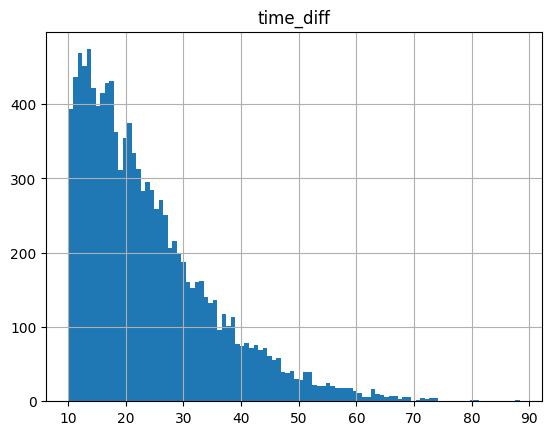

In [11]:
save_df[['time_diff']].to_pandas().hist(bins=100)

In [12]:
save_df.head()

lane,lane_index,vehicle_id,vehicle_id_leader,other_leader,time_diff,dist_diff,dist_diff_min,dist_diff_max,time_headway,time_headway_min,time_headway_max,start_index,end_index,min_acceleration,max_acceleration,association_distance,association_distance_leader
str,u16,u64,u64,u32,f64,f64,f64,f64,f64,f64,f64,u32,u32,f64,f64,f32,f32
"""EBL1""",0,144,139,0,57.3,33.160529,21.742096,49.428357,1.740817,1.192503,2.710754,341928,18900487,-0.787258,1.127892,2.239784,2.00647
"""EBL1""",0,139,151,0,34.4,76.96182,46.023159,108.750468,3.733635,2.372384,5.229238,5272315,17640962,-0.603123,0.792332,2.00647,2.100553
"""WBL1""",0,357,348,0,43.4,118.510082,102.340347,131.089884,5.763535,5.03,6.440472,291318,15383450,-1.055965,0.910664,2.266083,2.383987
"""WBL1""",0,321,317,0,13.8,171.35225,167.735925,181.654725,7.411262,7.025786,8.901469,12364953,17991403,-0.811996,1.044483,2.359867,2.335791
"""WBL1""",0,331,344,1,24.5,102.954687,93.253229,115.523961,4.52974,3.720745,5.666955,8377156,18467913,-0.700989,0.962563,2.291537,2.750962


In [13]:
# lf_df.select(["vehicle_id_leader", "vehicle_id", "association_distance", "association_distance_leader"]).filter(
#     (pl.col("association_distance") < 5)
#      & (pl.col("association_distance_leader") < 5)
# ).write_parquet(
#     "/Bit"   
# )

In [46]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def add_lowes(df: pl.DataFrame, col: str, time_col: str) -> pl.DataFrame:
    return df.with_columns(
        pl.struct([f"{col}", time_col])
        .map_elements(
            lambda x: pl.Series(
                values=lowess(
                    x.struct[f"{col}"],
                    x.struct[time_col],
                    frac=1 / 3,
                    it=2,
                    is_sorted=True,
                )[:, 1]
            ),
            # strategy="threading"
        )
        .over("vehicle_id")
        .alias(f"{col}_lowes")
    )


vehicle_id = 16
follower_id = vehicle_id

traj_df = processed_traj_df.sort(["epoch_time", "front_s_smooth"])

plot_df = (
    traj_df
    .filter((pl.col("vehicle_id") == follower_id))
    .join_asof(
        traj_df.with_context(
            lf_df.select(["vehicle_id_leader", "vehicle_id", "association_distance", "association_distance_leader"])
            .lazy()
            .filter(
                (pl.col("vehicle_id") == follower_id)
                & (pl.col("association_distance") < 5)
                & (pl.col("association_distance_leader") < 5)
            )
        )
        .filter(
            (pl.col("vehicle_id").is_in(pl.col("vehicle_id_leader")))
            & (pl.col("vehicle_id") != follower_id)
        )
        .select(
            [
                "front_s_smooth",
                pl.col("front_s_smooth").alias("front_s_smooth_leader"),
                "epoch_time",
                "lane",
                "lane_index",
                "s_velocity_smooth",
                pl.col("vehicle_id").alias("vehicle_id_leader"),
            ]
        ),
        on="front_s_smooth",
        by=["epoch_time", "lane", "lane_index"],
        strategy="forward",
        suffix="_leader",
    )
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("epoch_time")
            .filter(pl.col("vehicle_id_leader").is_not_null())
            .first(),
            pl.col("epoch_time")
            .filter(pl.col("vehicle_id_leader").is_not_null())
            .last(),
        )
    )
    # .with_columns(pl.col("vehicle_id_leader").cast(str).unique().str.concat("_"))
    .with_columns(
        # pl.col("vehicle_id_leader").cast(str).unique().str.concat("_"),
        # (pl.col("ci_front_s").max() - pl.col("ci_front_s")),
        (
            (pl.col("epoch_time") - pl.col("epoch_time").first()).dt.milliseconds()
            / 1000
        ).alias("sim_time"),
        # pl.col(["front_s_smooth", "front_s_smooth_leader"]).map_batches(
        #     lambda col: col.shift_and_fill(
        #         pl.col(col.name).first() - pl.col("s_velocity_smooth").first() * 0.1
        #     ).over("vehicle_id")
        # ),
        # *(
        #     pl.col(f"front_s_smooth{ext}")
        #     .shift_and_fill(
        #         pl.col(f"front_s_smooth{ext}").first()
        #         - pl.col(f"s_velocity_smooth{ext}").first() * 0.1
        #     )
        #     .over(f"vehicle_id{ext}")
        #     for ext in ["", "_leader"]
        # ),
    )
    .pipe(add_lowes, "front_s_smooth", "sim_time")
    .pipe(add_lowes, "s_velocity_smooth", "sim_time")
    .pipe(add_lowes, "front_s_smooth_leader", "sim_time")
    .pipe(add_lowes, "s_velocity_smooth_leader", "sim_time")
    .collect()

    .sort("epoch_time")
    # .collect()
)


# plot_df = (
#     processed_traj_df.filter(pl.col("vehicle_id").is_in([vehicle_id]))
#     .join_asof(
#         processed_traj_df.with_context(
#             bad_leaders.lazy().filter(pl.col("vehicle_id") == vehicle_id).select(
#                 pl.all().name.suffix("_bad")
#             )
#         )
#         .filter(
#             (
#                 (pl.col('vehicle_id') != vehicle_id)
#                 & (~pl.col("vehicle_id").is_in(pl.col("vehicle_id_leader_bad")))
#             )
#         )
#         # .sort(["epoch_time", "front_s_smooth"])
#         .select(["vehicle_id", "front_s_smooth", "merge_hash"])
#         .with_columns(pl.col("front_s_smooth").alias("front_s_smooth_leader")),
#         on="front_s_smooth",
#         by=["merge_hash"],
#         strategy="forward",
#         allow_parallel=False
#     )
#     .collect()
# )

/tmp/ipykernel_3654349/3328002589.py:76: DeprecationWarning:

`milliseconds` is deprecated. It has been renamed to `total_milliseconds`.



In [47]:
plot_df

epoch_time,lane,lane_index,s_velocity_smooth,vehicle_id,front_s_smooth,association_distance,length_s,front_s_smooth_leader,s_velocity_smooth_leader,vehicle_id_leader,sim_time,front_s_smooth_lowes,s_velocity_smooth_lowes,front_s_smooth_leader_lowes,s_velocity_smooth_leader_lowes
"datetime[ms, UTC]",str,u16,f32,u64,f64,f32,f64,f64,f32,u64,f64,f64,f64,f64,f64
2023-03-12 21:41:27.400 UTC,"""EBL1""",0,4.081182,16,1152.681053,null,4.051945,1194.334744,2.709592,51482,0.0,1151.697595,0.50002,1194.881865,3.1493
2023-03-12 21:41:27.500 UTC,"""EBL1""",0,4.019397,16,1153.086082,null,4.051945,1194.504115,2.839556,51482,0.1,1152.070438,0.580365,1194.841975,3.212108
2023-03-12 21:41:27.600 UTC,"""EBL1""",0,3.893015,16,1153.439438,null,4.047107,1194.748393,2.981212,51482,0.2,1152.443811,0.660769,1194.802959,3.275003
2023-03-12 21:41:27.700 UTC,"""EBL1""",0,3.712986,16,1153.871782,null,4.041534,1195.072366,3.128945,51482,0.3,1152.817729,0.74123,1194.764881,3.337994
2023-03-12 21:41:27.800 UTC,"""EBL1""",0,3.492059,16,1154.305087,null,4.04505,1195.478089,3.282834,51482,0.4,1153.192208,0.82175,1194.727804,3.401088
2023-03-12 21:41:27.900 UTC,"""EBL1""",0,3.240832,16,1154.513227,null,4.04029,1195.825096,3.435801,51482,0.5,1153.56726,0.902326,1194.691798,3.464295
2023-03-12 21:41:28 UTC,"""EBL1""",0,2.973034,16,1154.840586,null,4.048717,1196.116693,3.586535,51482,0.6,1153.942897,0.98296,1194.656928,3.527625
2023-03-12 21:41:28.100 UTC,"""EBL1""",0,2.70252,16,1155.159684,null,4.049711,1196.515389,3.731513,51482,0.7,1154.319129,1.06365,1194.623262,3.591089
2023-03-12 21:41:28.200 UTC,"""EBL1""",0,2.443104,16,1155.331293,null,4.046856,1196.984142,3.865318,51482,0.8,1154.695965,1.144396,1194.59086,3.654696


## Plot some of the Vehicle Trajectories

In [49]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

for vehicle_id in plot_df["vehicle_id"].unique().to_list():
    fig.add_trace(
        go.Scatter(
            x=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["sim_time"],
            y=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["front_s_smooth_lowes"],
            mode="lines",
            name=f"vehicle_id: {vehicle_id}",
            # color by the lane index
        )
    )


for vehicle_id in plot_df["vehicle_id_leader"].unique().to_list():
    fig.add_trace(
        go.Scatter(
            x=plot_df.filter(pl.col("vehicle_id_leader") == vehicle_id)["sim_time"],
            y=plot_df.filter(pl.col("vehicle_id_leader") == vehicle_id)[
                "front_s_smooth_leader_lowes"
            ],
            mode="lines",
            name=f"vehicle_id_leader: {vehicle_id}",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["sim_time"],
            y=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["front_s_smooth"],
            mode="lines",
            name=f"vehicle_id: {vehicle_id} raw",
            # color by the lane index
        )
    )

fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

for vehicle_id in plot_df["vehicle_id"].unique().to_list():
    fig.add_trace(
        go.Scatter(
            x=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["sim_time"],
            y=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["lowess"],
            mode="lines",
            name=f"vehicle_id: {vehicle_id}",
            # color by the lane index
        )
    )

for vehicle_id in plot_df["vehicle_id_leader"].unique().to_list():
    fig.add_trace(
        go.Scatter(
            x=plot_df.filter(pl.col("vehicle_id_leader") == vehicle_id)["sim_time"],
            y=plot_df.filter(pl.col("vehicle_id_leader") == vehicle_id)[
                "lowess_leader"
            ],
            mode="lines",
            name=f"vehicle_id_leader: {vehicle_id}",
        )
    )

fig.show()import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

for vehicle_id in plot_df["vehicle_id"].unique().to_list():
    fig.add_trace(
        go.Scatter(
            x=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["sim_time"],
            y=plot_df.filter(pl.col("vehicle_id") == vehicle_id)["lowess"],
            mode="lines",
            name=f"vehicle_id: {vehicle_id}",
            # color by the lane index
        )
    )

for vehicle_id in plot_df["vehicle_id_leader"].unique().to_list():
    fig.add_trace(
        go.Scatter(
            x=plot_df.filter(pl.col("vehicle_id_leader") == vehicle_id)["sim_time"],
            y=plot_df.filter(pl.col("vehicle_id_leader") == vehicle_id)[
                "lowess_leader"
            ],
            mode="lines",
            name=f"vehicle_id_leader: {vehicle_id}",
        )
    )

fig.show()

In [18]:
import plotly.express as px
import statsmodels.nonparametric.smoothers_lowess as lowess

_traj_df = traj_df.filter(pl.col("vehicle_id").is_in([follower_id])).collect().sort("epoch_time").clone()

s = lowess.lowess(
    _traj_df['front_s_smooth'].to_numpy(),
    _traj_df['epoch_time'].to_numpy(),
    frac=1/3,
    it=2,
    is_sorted=True,
)


fig = px.scatter(
    _traj_df.to_pandas(),
    x="epoch_time",
    y=["front_s_smooth", ],
    color="lane_index",
    title="Trajectory",
    # make second y axis
)

fig.add_trace(
    go.Scatter(
        x=_traj_df['epoch_time'],
        y=s[:, 1],
        mode="lines",
        name="lowess",
    )
)


y = lowess.lowess(
    _traj_df['s_velocity_smooth'].to_numpy(),
    _traj_df['epoch_time'].to_numpy(),
    frac=1/3,
    it=2,
    is_sorted=True,
)

other_fig = px.scatter(
    _traj_df.with_columns(pl.col('s_velocity_smooth').rolling_mean(window_size=50, center=True, min_periods=1).alias('rolling')).to_pandas(),
    x="epoch_time",
    y=["s_velocity_smooth", "rolling"],
    # color="lane_index",
    title="Velocity",
    # make second y axis
)

other_fig.add_trace(
    go.Scatter(
        x=_traj_df['epoch_time'],
        y=y[:, 1],
        mode="lines",
        name="lowess",
    )
)

fig.show()
other_fig.show()

In [19]:
# fig = px.scatter(
#     _traj_df.to_pandas(),
#     x="epoch_time",
#     y="s_velocity_smooth",
#     color="lane_index",
#     title="Trajectory",
# )

# fig.show()

<Axes: >

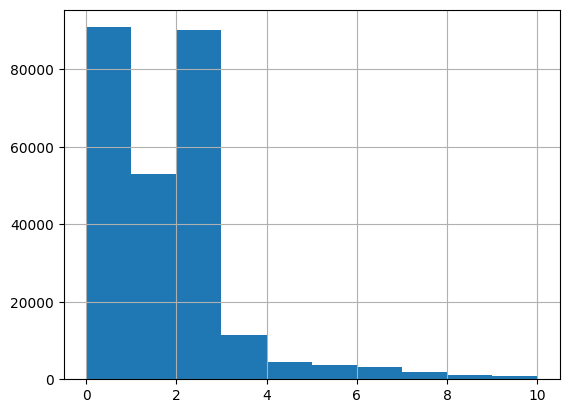

In [20]:
lf_df.filter(pl.col("association_distance") < 10)[
    "association_distance"
].to_pandas().hist()

In [21]:
# save_df.head()
save_df.write_parquet(
    "/BittleLab/7 DOE Project/radar-data/prepared_data/calibration/leaders.parquet",
)

In [22]:
processed_traj_df.collect().with_columns(
    pl.struct(['front_s_smooth', 'epoch_time']).map_elements(
        lambda x: lowess.lowess(
            x.struct['front_s_smooth'],
            x.struct['epoch_time'],
            frac=1/3,
            it=2,
            is_sorted=True,
        )[:, 1],
        strategy="threading"
        ).over('vehicle_id').alias('lowess')
)


/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning:

divide by zero encountered in divide

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning:

invalid value encountered in divide

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning:

divide by zero encountered in divide

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning:

invalid value encountered in divide

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning:

invalid value encountered in multiply

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarnin

In [20]:
processed_traj_df.collect().write_parquet(
    "/BittleLab/7 DOE Project/radar-data/prepared_data/calibration/processed_traj.parquet",
    use_pyarrow=True,
)

In [21]:
lf_df.select(["vehicle_id_leader", "vehicle_id", "association_distance", "association_distance_leader"]).filter(
    (pl.col("association_distance") < 5)
     & (pl.col("association_distance_leader") < 5)
).write_parquet(
    "/BittleLab/7 DOE Project/radar-data/prepared_data/calibration/candidate_leaders.parquet",   
)

In [19]:
# processed_traj_df.filter(
#     pl.col("vehicle_id").is_in(save_df["vehicle_id"])
#     | pl.col("vehicle_id").is_in(save_df["vehicle_id_leader"])
# ).sink_parquet(ROOT.joinpath("data/leader_follower_sample_traj.parquet"))